<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION/blob/main/CorrectXGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [ ]:
# Load dataset
data1 = pd.read_csv("GFI_dataset.csv")

# Convert Date column to datetime
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values('Date')
data1.set_index('Date', inplace=True)

print(data1.head())


                  Close         High          Low         Open
Date                                                          
2012-12-31  9091.963867  9151.554951  8999.072886  9104.232763
2013-01-01  9091.963867  9091.963867  9091.963867  9091.963867
2013-01-02  9323.318359  9325.946504  9043.767691  9151.556707
2013-01-03  9335.583984  9376.772209  9183.978625  9289.138496
2013-01-04  9049.024414  9131.399905  8955.256723  9113.873744


/tmp/ipython-input-218794384.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data1['Date'] = pd.to_datetime(data1['Date'])


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Loop through each feature
for col in ["Close", "High", "Low", "Open"]:
    result = adfuller(data1[col].dropna())
    print(f"Feature: {col}")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    print("-" * 40)

Feature: Close
  ADF Statistic: -0.8927524476821448
  p-value: 0.790349769845352
----------------------------------------
Feature: High
  ADF Statistic: -1.129604601213029
  p-value: 0.7031227284341343
----------------------------------------
Feature: Low
  ADF Statistic: -1.0113363349123317
  p-value: 0.7491072102344439
----------------------------------------
Feature: Open
  ADF Statistic: -1.0917706683810122
  p-value: 0.7183424850696943
----------------------------------------


In [ ]:
# Define the ADF test function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('-'*50)

# Select numeric features (Close, High, Low, Open, etc.)
features = data1.select_dtypes(include=[np.number]).columns

# Calculate percentage change (returns)
data_returns = data1[features].pct_change().dropna()

# Run ADF test on each feature
for col in features:
    adf_test(data_returns[col], title=f"{col} (Returns)")

Augmented Dickey-Fuller Test: Close (Returns)
ADF Statistic: -40.17952119272028
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: High (Returns)
ADF Statistic: -39.88932325419743
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Low (Returns)
ADF Statistic: -13.49927808718864
p-value: 2.9990343346863835e-25
--------------------------------------------------
Augmented Dickey-Fuller Test: Open (Returns)
ADF Statistic: -18.951097277075363
p-value: 0.0
--------------------------------------------------


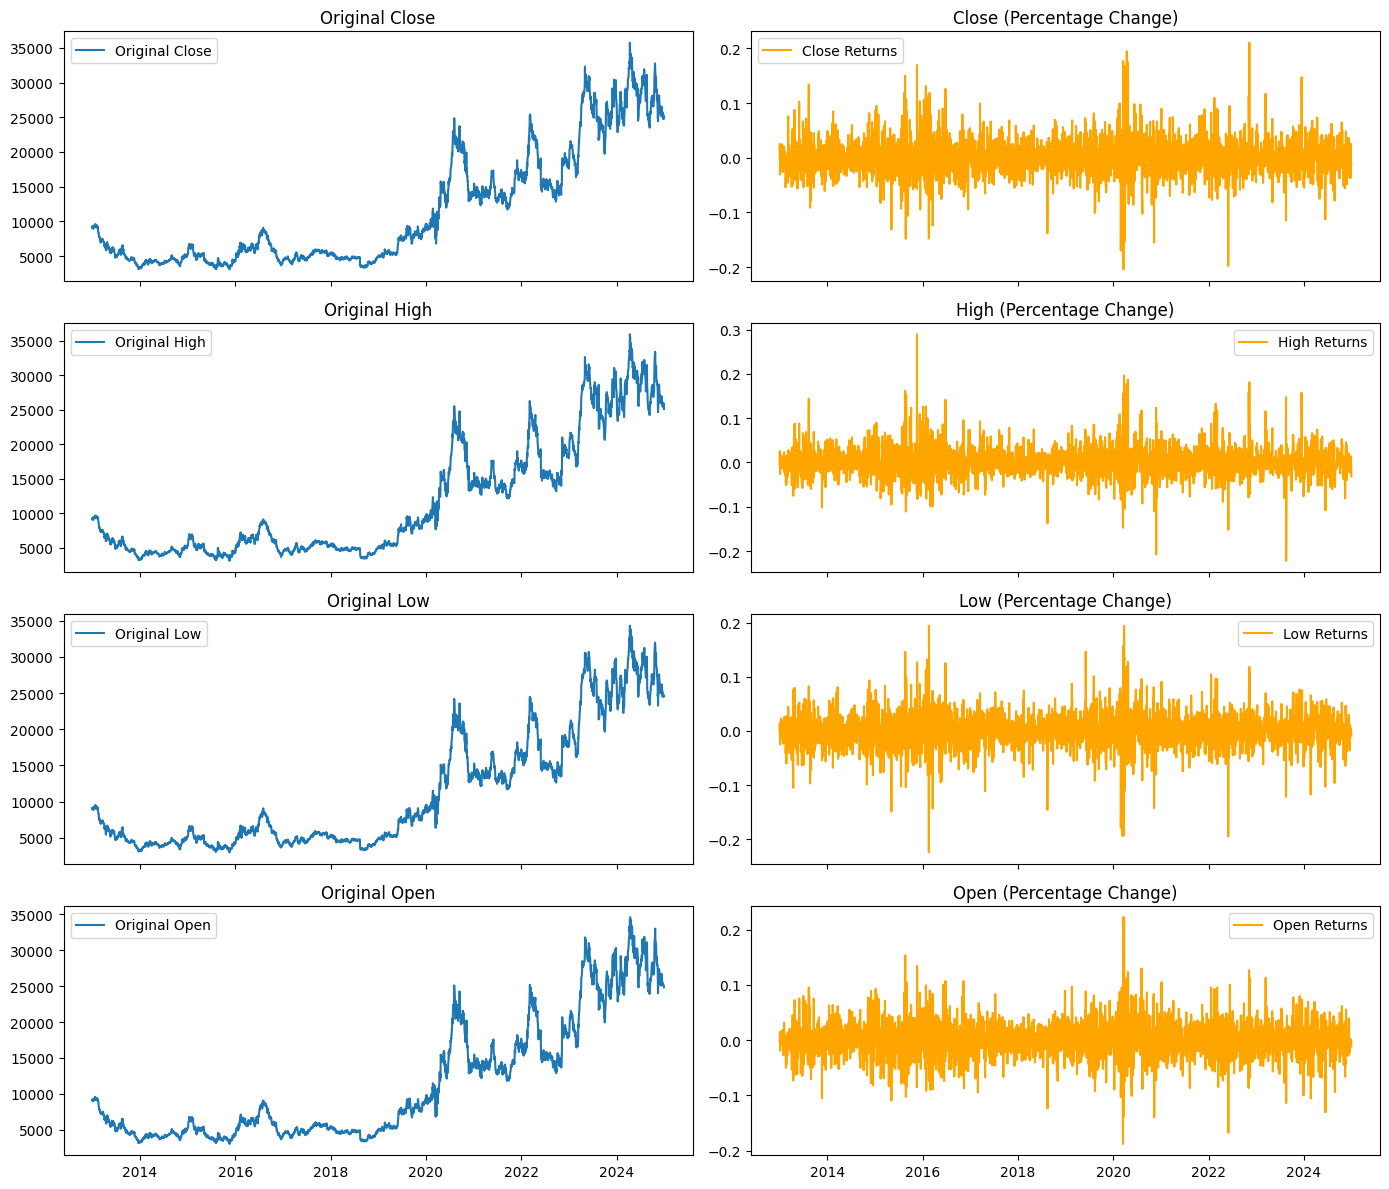

In [ ]:
# Create subplots with 2 columns: Original vs Returns
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(14, 3*n_features), sharex=True)

for i, col in enumerate(features):
    # Original series
    axes[i,0].plot(data1[col], label=f"Original {col}")
    axes[i,0].set_title(f"Original {col}")
    axes[i,0].legend()

    # Returns series
    axes[i,1].plot(data_returns[col], label=f"{col} Returns", color='orange')
    axes[i,1].set_title(f"{col} (Percentage Change)")
    axes[i,1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save only the stationary returns dataset
data_returns.to_csv("GFI_dataset_returns.csv", index=True)

print("✅ Stationary dataset saved as 'GFI_dataset_returns.csv'")

✅ Stationary dataset saved as 'GFI_dataset_returns.csv'


In [ ]:
from sklearn.preprocessing import StandardScaler

# ===============================
# Train-Test Split (XGB)
# ===============================
train_XGB = data_returns[data_returns.index < "2023-01-01"]
test_XGB = data_returns[data_returns.index >= "2023-01-01"]

# Features (X) and Target (y)
X_train_XGB = train_XGB[["High", "Low", "Open"]]
y_train_XGB = train_XGB["Close"]

X_test_XGB = test_XGB[["High", "Low", "Open"]]
y_test_XGB = test_XGB["Close"]

print("Before scaling (XGB):")
print("Train shape (XGB):", X_train_XGB.shape, y_train_XGB.shape)
print("Test shape (XGB):", X_test_XGB.shape, y_test_XGB.shape)

# ===============================
# Scaling (XGB)
# ===============================
scaler_XGB = StandardScaler()

X_train_scaled_XGB = scaler_XGB.fit_transform(X_train_XGB)
X_test_scaled_XGB = scaler_XGB.transform(X_test_XGB)

print("\nAfter scaling (XGB):")
print("X_train_scaled shape (XGB):", X_train_scaled_XGB.shape)
print("X_test_scaled shape (XGB):", X_test_scaled_XGB.shape)


Before scaling:
Train shape: (2551, 3) (2551,)
Test shape: (497, 3) (497,)

After scaling:
X_train_scaled shape: (2551, 3)
X_test_scaled shape: (497, 3)


In [ ]:
# ===============================
# XGBoost Regression Model (XGB)
# ===============================
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialise and fit model
xgb_model_XGB = XGBRegressor(n_estimators=100, random_state=42)  # you can tune hyperparameters later
xgb_model_XGB.fit(X_train_scaled_XGB, y_train_XGB)

# ===============================
# Predictions
# ===============================
y_pred_XGB = xgb_model_XGB.predict(X_test_scaled_XGB)

# ===============================
# Evaluation
# ===============================
mse_XGB = mean_squared_error(y_test_XGB, y_pred_XGB)
r2_XGB = r2_score(y_test_XGB, y_pred_XGB)

print("\n✅ XGBoost Regression Model Evaluation (XGB)")
print("MSE (XGB):", mse_XGB)
print("R² (XGB):", r2_XGB)



XGBoost Regression Model Evaluation
MSE: 0.00037202029723274274
R²: 0.5272822665492257


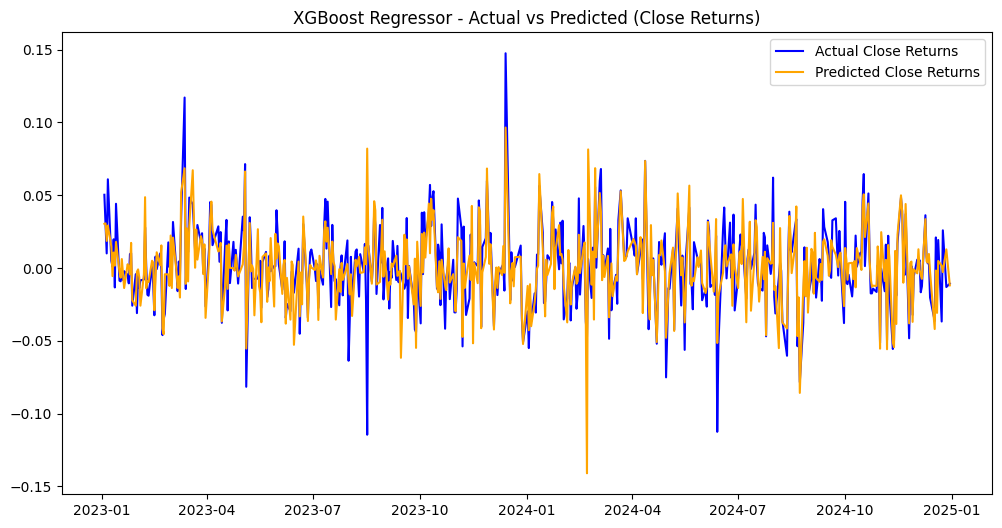

In [ ]:
# ===============================
# Visualise Actual vs Predicted (XGB)
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_XGB.index, y_test_XGB, label="Actual Close Returns (XGB)", color="blue")
plt.plot(y_test_XGB.index, y_pred_XGB, label="Predicted Close Returns (XGB)", color="orange")

plt.title("XGBoost Regressor (XGB) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()



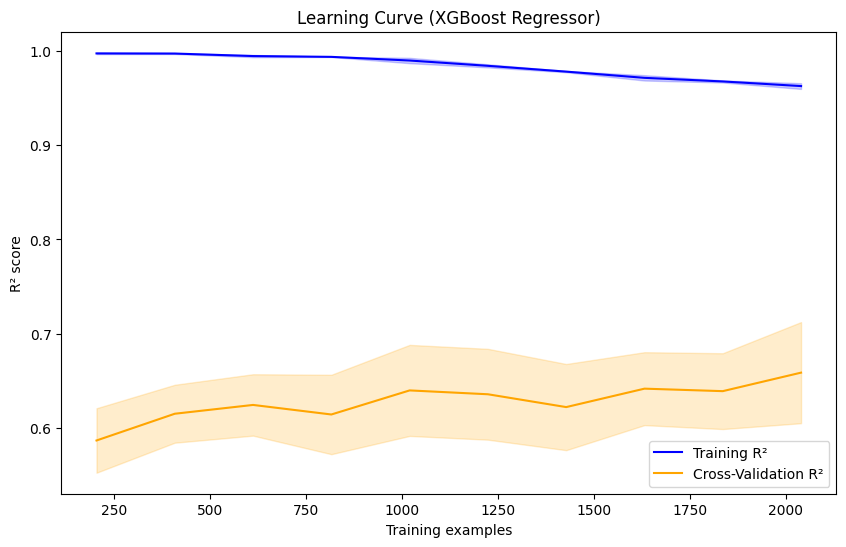

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor

# ===============================
# Define XGBoost model (XGB)
# ===============================
xgb_model_XGB = XGBRegressor(n_estimators=100, random_state=42)

# ===============================
# Generate learning curve (XGB)
# ===============================
train_sizes_XGB, train_scores_XGB, test_scores_XGB = learning_curve(
    estimator=xgb_model_XGB,
    X=X_train_scaled_XGB,
    y=y_train_XGB,
    cv=5,                     # 5-fold cross validation
    scoring="r2",             # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# ===============================
# Calculate mean and std (XGB)
# ===============================
train_mean_XGB = np.mean(train_scores_XGB, axis=1)
train_std_XGB = np.std(train_scores_XGB, axis=1)
test_mean_XGB = np.mean(test_scores_XGB, axis=1)
test_std_XGB = np.std(test_scores_XGB, axis=1)

# ===============================
# Plot Learning Curve (XGB)
# ===============================
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_XGB, train_mean_XGB, label="Training R² (XGB)", color="blue")
plt.plot(train_sizes_XGB, test_mean_XGB, label="Cross-Validation R² (XGB)", color="orange")

plt.fill_between(train_sizes_XGB, train_mean_XGB-train_std_XGB, train_mean_XGB+train_std_XGB, alpha=0.2, color="blue")
plt.fill_between(train_sizes_XGB, test_mean_XGB-test_std_XGB, test_mean_XGB+test_std_XGB, alpha=0.2, color="orange")

plt.title("Learning Curve (XGBoost Regressor - XGB)")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.show()



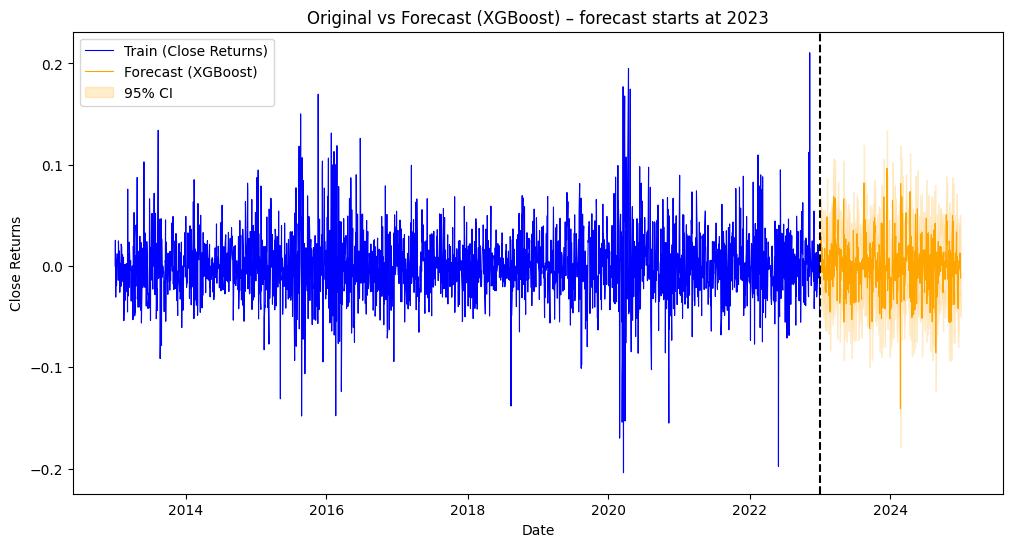

In [ ]:
# ===============================
# Forecast with actual date index (XGB)
# ===============================

# Error and confidence interval (make sure y_pred_XGB is inverse transformed if needed)
error_XGB = y_test_XGB.values - y_pred_XGB
err_std_XGB = np.std(error_XGB)
lower_XGB = y_pred_XGB - 1.96 * err_std_XGB
upper_XGB = y_pred_XGB + 1.96 * err_std_XGB

plt.figure(figsize=(12, 6))

# Training data (blue) – use actual index
plt.plot(y_train_XGB.index, y_train_XGB.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Forecast (orange) – align with test index
plt.plot(y_test_XGB.index, y_pred_XGB, label="Forecast (XGBoost - XGB)", color="orange", linewidth=0.8)

# Confidence Interval
plt.fill_between(y_test_XGB.index, lower_XGB, upper_XGB, color="orange", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_XGB.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (XGBoost - XGB) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()



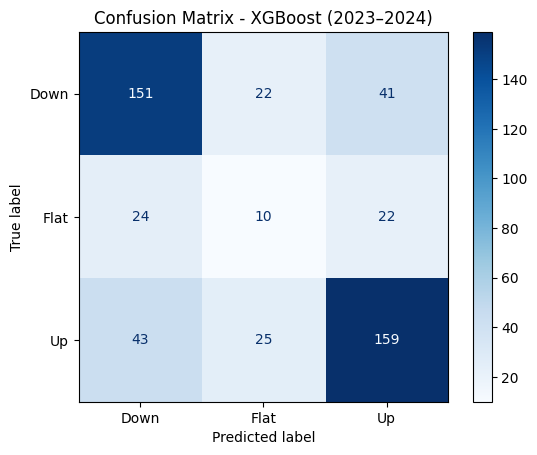

Classification Report - XGBoost
              precision    recall  f1-score   support

        Down       0.69      0.71      0.70       214
        Flat       0.18      0.18      0.18        56
          Up       0.72      0.70      0.71       227

    accuracy                           0.64       497
   macro avg       0.53      0.53      0.53       497
weighted avg       0.65      0.64      0.64       497



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays (XGB) ---
y_test_arr_XGB = np.array(y_test_XGB).flatten()
y_pred_arr_XGB = np.array(y_pred_XGB).flatten()

# --- 2. Convert regression outputs into classes (XGB) ---
def to_class_XGB(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)  # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

# --- 3. Compute daily differences (XGB) ---
delta_true_XGB = np.diff(y_test_arr_XGB, prepend=y_test_arr_XGB[0])
delta_pred_XGB = np.diff(y_pred_arr_XGB, prepend=y_pred_arr_XGB[0])

# --- 4. Convert differences to classes (XGB) ---
true_cls_XGB = to_class_XGB(delta_true_XGB)
pred_cls_XGB = to_class_XGB(delta_pred_XGB)

# --- 5. Confusion Matrix (XGB) ---
labels_XGB = [-1, 0, 1]  # Down, Flat, Up
cm_XGB = confusion_matrix(true_cls_XGB, pred_cls_XGB, labels=labels_XGB)

disp_XGB = ConfusionMatrixDisplay(confusion_matrix=cm_XGB, display_labels=["Down", "Flat", "Up"])
disp_XGB.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - XGBoost (XGB) (2023–2024)")
plt.show()

# --- 6. Classification Report (XGB) ---
print("Classification Report - XGBoost (XGB)")
print(classification_report(true_cls_XGB, pred_cls_XGB, target_names=["Down", "Flat", "Up"]))



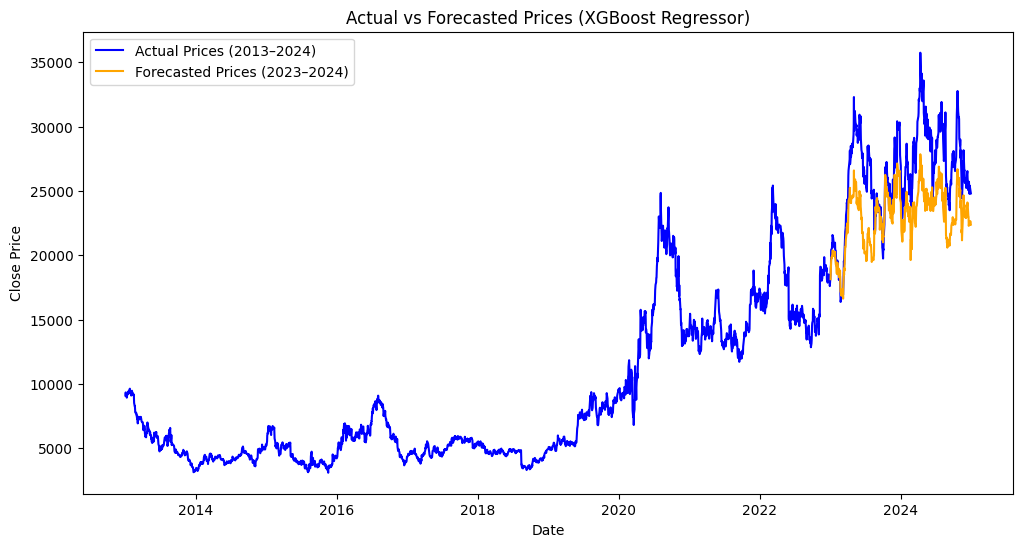

In [ ]:
# ===============================
# 1. Reconstruct ACTUAL prices from returns (2013–2024) - XGB
# ===============================
P0_XGB = data1["Close"].iloc[0]  # first actual price in 2013
reconstructed_prices_XGB = (1 + data_returns["Close"]).cumprod() * P0_XGB

# ===============================
# 2. Reconstruct FORECASTED prices from returns (2023–2024) - XGB
# ===============================
last_price_2022_XGB = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]  # last actual before forecast

forecast_prices_XGB = (1 + pd.Series(y_pred_XGB, index=y_test_XGB.index)).cumprod() * last_price_2022_XGB

# ===============================
# 3. Plot Actual vs Forecasted Prices - XGB
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Actual reconstructed prices
plt.plot(reconstructed_prices_XGB.index, reconstructed_prices_XGB,
         label="Actual Prices (2013–2024)", color="blue")

# Forecasted prices
plt.plot(forecast_prices_XGB.index, forecast_prices_XGB,
         label="Forecasted Prices (2023–2024)", color="orange")

plt.title("Actual vs Forecasted Prices (XGBoost Regressor - XGB)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()



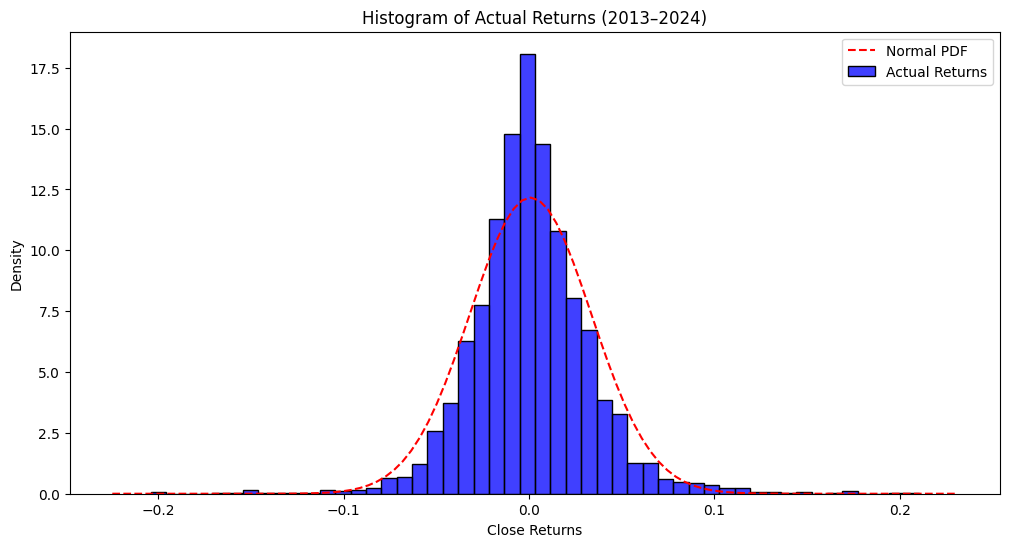

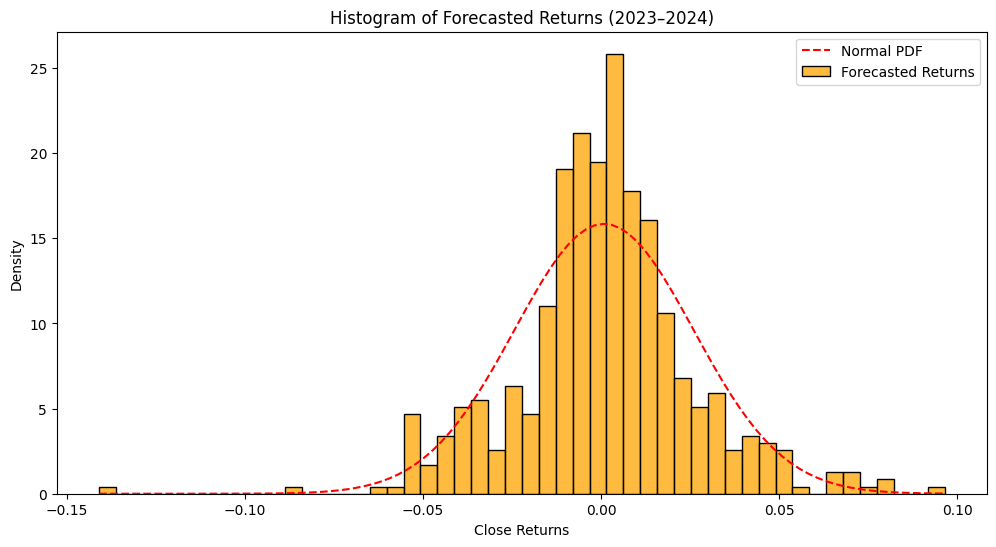

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# ==============================
# Histogram of ACTUAL returns (2013–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(data_returns["Close"], bins=50, kde=False, color="blue", stat="density", label="Actual Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(data_returns["Close"].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Actual Returns (2013–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

# ==============================
# Histogram of FORECASTED returns (2023–2024)
# ==============================
plt.figure(figsize=(12,6))
sns.histplot(y_pred, bins=50, kde=False, color="orange", stat="density", label="Forecasted Returns")

# Fit and plot normal PDF
mu, std = stats.norm.fit(y_pred)
x = np.linspace(min(y_pred), max(y_pred), 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r--", label="Normal PDF")

plt.title("Histogram of Forecasted Returns (2023–2024)")
plt.xlabel("Close Returns")
plt.ylabel("Density")
plt.legend()
plt.show()
